In [1]:
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\VARTUL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
#add start and end tags:
def add_start_end_tag(sentences_original):
    sentences=[""]*len(sentences_original)
    for i in range(len(sentences_original)):
        sentences[i]=[("<start>","<start>")]+sentences_original[i]+[("<end>","<end>")]
    return sentences

In [4]:
def remove_tags(sentence):
    new_sentence=[]
    for i in sentence:
        new_sentence.append(i[0])

    # print(new_sentence)

    return new_sentence

In [5]:
#splits data in k sets:
def k_splits (k, data):
    splits = {}
    n = len(data)//k
    for i in range(0, k):
        i = int(i)
        if(i+1 == k):
            splits[i]= data[n*i : ]
        else:
            splits[i]=data[n*i : n*(i+1)]
    return splits

In [6]:
def precision(confusion_matrix):
    precision = []
    n = len(confusion_matrix)
    for i in range(0,n):
        sum = 0
        for j in range(0,len(confusion_matrix[i])):
            sum+=confusion_matrix[j][i]
        precision.append(confusion_matrix[i][i]/sum)

    return precision

In [7]:
def recall(confusion_matrix):
    recall = []
    n = len(confusion_matrix)
    for i in range(0,n):
        sum = 0
        for j in range(0,len(confusion_matrix[i])):
            sum+=confusion_matrix[i][j]
        recall.append(confusion_matrix[i][i]/sum)

    return recall

In [8]:
def accuracy_calculator (confusion_matrix):
    actual=0
    count=0
    for i in range(0,len(confusion_matrix)):
        actual+=confusion_matrix[i][i]
        count+=sum(confusion_matrix[i])
    return (actual/count)

In [9]:
def heatmap(confusion_matrix):

    # Example data
    data = confusion_matrix/np.sum(confusion_matrix,axis=1)

    # Create the heatmap
    plt.imshow(data,  cmap='Spectral', interpolation='none')

    # Add a colorbar
    plt.colorbar()

    # Add labels (optional)
    plt.title('Heatmap Example')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    # Display the plot
    return plt.show()


In [10]:
class HMM_model:
    def __init__(self):
        self.confusion_matrix=None
        self.transition_matrix=None
        self.emission_matrix=None
        self.tags_to_idx=None
        self.count_of_each_tag=None
        self.idx_to_tag=None
        self.word_to_idx=None
        self.idx_to_word=None
    
    def creat_tags_meta(self,sentences):
        
        #tag_to_idx: given a tag, what is its index : tags dict {"tag" : "tag_index"}
        #idx_to_tag: given an index what is the tag : tags_reverse list of string
        #count_of_each_tag: count of each tag
        self.tag_to_idx={}
        self.idx_to_tag=[]
        cnt = 0
        self.count_of_each_tag=[]
        for i in range(len(sentences)):
            for j in sentences[i]:
                if j[1] not in self.tag_to_idx:
                    self.tag_to_idx[j[1]] = cnt
                    self.idx_to_tag.append(j[1])
                    self.count_of_each_tag.append(0)
                    cnt += 1
                self.count_of_each_tag[self.tag_to_idx[j[1]]]+=1


    def create_word_idx_translation(self,sentences):
        #word to index number
        #word_to_idx is word to index number
        #idx_to_word
        
        idx = 0
        self.word_to_idx={}
        self.idx_to_word = []
        # word_to_idx["<start>"]=idx
        for sentence in sentences:
            for tup in sentence:
                if tup[0] not in self.word_to_idx:
                    
                    self.word_to_idx[tup[0]]=idx
                    idx += 1
                    self.idx_to_word.append(tup[0])
        self.word_to_idx["<unknown>"]=idx
        self.idx_to_word.append("<unknown>")

        # print('idx--------------------------------', idx)
        # print('worddict--------------------------------', len(word_to_idx))


    def create_transition_matrix(self,sentences):
        #creating transition matrix
        #bigram_matrix : count of every bigram tags
        #transmission_matrix : probability of every bigram tags 
        self.bigram_matrix = []
        self.transition_matrix = []
        total_tags = len(self.count_of_each_tag)
        for i in range(total_tags): 
            self.bigram_matrix.append([0]*total_tags)
            self.transition_matrix.append([0]*total_tags)

        #creating a bigram matrix
        for sentence in sentences:
            for j in range(len(sentence)-1):
                self.bigram_matrix[self.tag_to_idx[sentence[j][1]]][self.tag_to_idx[sentence[j+1][1]]]+=1
        # print(bigram_matrix)
        
        #create transition matrix A
        for i in range(total_tags):
            for j in range(total_tags):
                self.transition_matrix[i][j]=(self.bigram_matrix[i][j]+1)/(self.count_of_each_tag[i] + len(self.count_of_each_tag))  #adding 1 to numerator and total unique tags in denominator for smoothing(Laplace)
        # print(transition_matrix)


    def create_emission_matrix(self,sentences):
        #emission_matrix : given a word, what is the probability of tag
        #emission_count_matrix : given a word, what is the count of each tag that it can have
        # words = list(brown.words())
        words_cnt = len(self.word_to_idx)
        total_tags = len(self.tag_to_idx)
        self.emission_matrix = []
        
        for i in range(words_cnt):
            self.emission_matrix.append([0]*total_tags)
        # print("--------------------------------------",len(word_to_idx))
        # print("------------------------", len(emission_matrix))
        # print("------------------------", word_to_idx['<unknown>'])
        
        for sentence in sentences:
            for j in sentence:
                self.emission_matrix[self.word_to_idx[j[0]]][self.tag_to_idx[j[1]]]+=1

        emission_count_matrix = self.emission_matrix

        for i in range(words_cnt):
            for j in range(total_tags):
                self.emission_matrix[i][j] = (self.emission_matrix[i][j]+1)/(self.count_of_each_tag[j] + words_cnt)
        # print("------------------------", emission_matrix[word_to_idx['unknown'])

        # handling missing case
        aux=[0]*len(self.tag_to_idx.keys())
        # print(tag_to_idx)
        aux[self.tag_to_idx['NOUN']]=self.count_of_each_tag[self.tag_to_idx['NOUN']]/total_tags
        aux[self.tag_to_idx['VERB']]=self.count_of_each_tag[self.tag_to_idx['VERB']]/total_tags
        aux[self.tag_to_idx['ADV']]=self.count_of_each_tag[self.tag_to_idx['ADV']]/total_tags
        aux[self.tag_to_idx['ADJ']]=self.count_of_each_tag[self.tag_to_idx['ADJ']]/total_tags
        # print(aux)
        self.emission_matrix[self.word_to_idx['<unknown>']]=aux


    def build_confusion_matrix(self,actual,predicted):
        #cm: confusion matrix
        for i in range(len(actual)):
            self.confusion_matrix[self.tag_to_idx[actual[i][1]]][self.tag_to_idx[predicted[i]]]+=1

    def HMM_logic(self,input_sentence):
        # print(tags_dict)
        tags_output=["<start>"]
        last_prob = 1
        viterbi=[]
        for i in range(len(self.tag_to_idx)):
            viterbi.append(([0])*len(input_sentence))
        
        viterbi[self.tag_to_idx["<start>"]][0]=1
        
        for i in range(1, len(input_sentence)):
            word_prob=0
            tags=""
            curr_ob = input_sentence[i]
            if curr_ob not in self.word_to_idx:
                curr_ob="<unknown>"
            for curr_tag in self.tag_to_idx:
                max_prob=0
                for prev_tag in self.tag_to_idx:
                    temp = self.transition_matrix[self.tag_to_idx[prev_tag]][self.tag_to_idx[curr_tag]]*self.emission_matrix[self.word_to_idx[curr_ob]][self.tag_to_idx[curr_tag]]*viterbi[self.tag_to_idx[prev_tag]][i-1]
                    if temp>max_prob:
                        max_prob=temp
                viterbi[self.tag_to_idx[curr_tag]][i]=max_prob
                if max_prob>word_prob:
                    word_prob=max_prob
                    tags=curr_tag
            if tags=='':
                tags='X'
            tags_output.append(tags)

        return tags_output  
    



    def train_model(self,sentences_original, k):

        model=HMM_model()

        sentences = add_start_end_tag(sentences_original)
        
        #spliting data into k splits
        cross_validation_set=k_splits(k,sentences)
        keys=list(cross_validation_set.keys())

        #creating master meta data i.e. over whole corpus
        self.creat_tags_meta(sentences)
        self.create_word_idx_translation(sentences)
        #instializing master transition, emission and confusion matrices
        master_transition_matrix = []
        master_emission_matrix = []
        master_confusion_matrix = []

        for i in range(len(self.count_of_each_tag)):
            master_transition_matrix.append([0]*len(self.count_of_each_tag))
            master_confusion_matrix.append([0]*len(self.count_of_each_tag))

        for i in range(len(self.word_to_idx)):
            master_emission_matrix.append([0]*len(self.count_of_each_tag))



        #model building and traing on k sets
        for i in keys:

            #**********************------------------create test and train------------------************************************
            train_data=[]
            for j in cross_validation_set.keys():
                if j!=i:
                    train_data+=cross_validation_set[j]

            test_data=cross_validation_set[i]
            #**********************---------------------------------------************************************
            

            #**********************---------------create tags and words meta data------------------------************************************
            model.creat_tags_meta(train_data)
            model.create_word_idx_translation(train_data)
            #**********************---------------------------------------************************************


            #**********************---------------build transition and emission matrix------------------------************************************
            
            #bigram_matrix : count of every bigram tags
            #transmission_matrix : probability of every bigram tags
            #emission_count_matrix : given a word, what is the count of each tag that it can have
            #emission_matrix : given a word, what is the probability of tag
            model.create_transition_matrix(train_data)
            model.create_emission_matrix(train_data)

            #**********************---------------------------------------************************************
            
            #**********************---------------initialize confustion matrix------------------------************************************
            #confusion_matrix : A matrix with rows having actual tag and columns showing predicted tag
            model.confusion_matrix=[]
            for j in range(len(model.count_of_each_tag)):
                model.confusion_matrix.append([0]*len(model.count_of_each_tag))
            #**********************---------------------------------------************************************


            #**********************---------------bulding confustion matrix------------------------************************************
            coun=0
            for sen in test_data:
                coun+=1
                tags_output = model.HMM_logic(remove_tags(sen))
                model.build_confusion_matrix(sen,tags_output)
            #**********************---------------------------------------************************************

            
            


            #**********************---------------build masters------------------------************************************
            for i in range(len(model.count_of_each_tag)):
                row = model.idx_to_tag[i]
                for j in range(len(self.count_of_each_tag)):
                    col = model.idx_to_tag[j]
                    master_transition_matrix[self.tag_to_idx[row]][self.tag_to_idx[col]] += model.transition_matrix[i][j]
                    master_confusion_matrix[self.tag_to_idx[row]][self.tag_to_idx[col]] += model.confusion_matrix[i][j]
            
            for i in range(len(model.word_to_idx)):
                row = model.idx_to_word[i]
                for j in range(len(self.count_of_each_tag)):
                    col = model.idx_to_tag[j]
                    master_emission_matrix[self.word_to_idx[row]][self.tag_to_idx[col]] += model.emission_matrix[i][j]
            
            #**********************---------------------------------------*******************************************
                

        self.confusion_matrix = np.array(master_confusion_matrix)/k
        self.transition_matrix=np.array(master_transition_matrix)/k
        self.emission_matrix=np.array(master_emission_matrix)/k


    
            



In [11]:
#taking data from corpus
sentences_original = brown.tagged_sents(tagset='universal')

In [88]:
model = HMM_model()
model.train_model(sentences_original, 5)

In [111]:
import re
with open('Twitter_chatGPT_tagged_sentences.txt', 'r') as file:
    # Read all lines and store them in a list
    lines = file.readlines()
for i in range(len(lines)):
    lines[i] = lines[i].replace('\\','')
# lines[13] = lines[13].replace('\\','')
lines[6] = lines[6].replace('â€™', '')
lines[7] = lines[7].replace('â€™', '')
twitter_data = []
for string_data in lines:
    # Original string with problematic characters
    # string_data = "[('<start>', '<start>'), ('Whoâ€™', 'X'), ('is', 'VERB'), ('predicted', 'VERB'), ('to', 'ADP'), ('remain', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('top', 'NOUN'), ('10', 'NUM'), ('of', 'ADP'), ('global', 'ADJ'), ('200', 'NUM'), ('so', 'ADV'), ('please', 'ADV'), ('letâ€™s', 'VERB'), ('get', 'VERB'), ('those', 'DET'), ('streams', 'NOUN'), ('back', 'ADV'), ('to', 'ADP'), ('keep', 'VERB'), ('it', 'PRON'), ('stable', 'ADJ'), ('cuz', 'X'), ('we', 'PRON'), ('dropped', 'VERB'), (',', '.'), ('focus', 'VERB'), ('on', 'ADP'), ('Apple', 'PROPN'), ('Music', 'PROPN'), ('as', 'ADP'), ('well', 'ADV'), ('<end>', '<end>')]"

    # Remove the outer brackets and split the string into individual tuples
    tuple_strings = string_data[1:-1].split("), (")

    # List to store the parsed tuples
    tuple_list = []

    # Iterate through each tuple string
    for tuple_str in tuple_strings:
        # Remove any quotes and spaces
        tuple_str = tuple_str.strip("()")
        # Split the tuple into its two elements
        elements = re.split(r",\s*(?=['\"])", tuple_str)  # Split on comma followed by space and quote
        # Clean up each element and remove surrounding quotes
        element_1 = elements[0].strip().strip("'\"")
        element_2 = elements[1].strip().strip("'\"")
        # Append as a tuple to the list
        tuple_list.append((element_1, element_2))


    # Output the result
    # print(tuple_list)
    data =  [t for t in tuple_list if t != ('', '')]
    # print(data)
    twitter_data.append(data)


            


In [112]:
predicted_data = []
for sentence in twitter_data:
    ls = []
    sent = remove_tags(sentence)
    predict = model.HMM_logic(sent)
    # print(sentence)
    for i in range(len(predict)):
        # print(predict[i])
        ls.append((sent[i], predict[i]))
    predicted_data.append(ls)


In [119]:
# predicted_data
# twitter_data

In [120]:
# Sample list
# my_list = ['apple', 'banana', 'cherry']

# Open a file in write mode
with open('twitter_predicted_data.txt', 'w') as file:
    for item in predicted_data:
        file.write(f"{item}\n")


In [72]:

# models=[]
# for i in range(2,11):
#     model=HMM_model()
#     model.train_model(sentences_original, i)
#     models.append(model)
#     print("Accuracy of k = ", i," is = ", accuracy_calculator(model.confusion_matrix))


KeyboardInterrupt: 

In [156]:
print("recall : ", recall(confusion_matrix))
print(count_of_each_tag)

recall :  [1.0, 0.9909063706493257, 0.9300074757401345, 0.8145029323586673, 0.905909712722298, 0.9531174447038668, 0.9994985260732557, 0.999598883850715, 0.8188267927950353, 0.990118214463579, 0.6401153240135438, 0.9382170511209308, 0.7786069651741292, 0.03391053391053392]
[57340, 137019, 275558, 83721, 182750, 144766, 147565, 57340, 56239, 38151, 29829, 49334, 14874, 1386]


In [76]:
print("precision : ", precision(confusion_matrix))

precision :  [1.0, 0.941530812257972, 0.8986341991959168, 0.879624516841524, 0.9668998128263225, 0.8679951446489986, 0.9779384563645536, 0.8877961901811987, 0.9195839391566939, 0.9899966655551851, 0.7854426002766252, 0.9751655629139073, 0.9314671814671814, 0.04]


In [82]:
print(accuracy_calculator(np_master_confusion_matrix))

0.9285327995284794


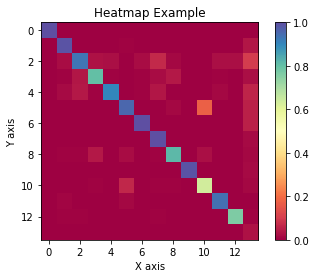

None
{'<start>': 0, 'DET': 1, 'NOUN': 2, 'ADJ': 3, 'VERB': 4, 'ADP': 5, '.': 6, '<end>': 7, 'ADV': 8, 'CONJ': 9, 'PRT': 10, 'PRON': 11, 'NUM': 12, 'X': 13}


In [83]:
print(heatmap(np_master_confusion_matrix))
print(master_tag_to_idx)

In [19]:
input_sentence1=["<start>", "Though","he","was","good","looking",",","she","rejected","him", ".", "<end>"]
tags_output= models[4].HMM_logic(input_sentence1)
print(tags_output)

['<start>', 'ADP', 'PRON', 'VERB', 'ADJ', 'VERB', '.', 'PRON', 'VERB', 'PRON', '.', '<end>']


In [23]:
s = input().split(" ")
s=["<start>"]+s+["<end>"]
print(s)
tags_output= models[4].HMM_logic(s)
p=[(s[i],tags_output[i]) for i in range(len(s))]
print(p)

SyntaxError: invalid syntax (34197387.py, line 5)